# SAT Optics Simulation: Far-Field

This notebook models the far-field beam of the Small Aperture Telescope.  We use the near-field beam simulated in the $\verb|sat_holography|$ notebook and the fourier relationship between near- and far-fields to propagate this beam into the far-field. 

Grace E. Chesmore
March 2022

### Read in the near-field beam


In [92]:
import numpy as np
import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib inline

# import sosat_optics
# from sosat_optics import ot_geo, ray_trace, opt_analyze

# %load_ext blackcellmagic

# Figure styling
font_manager.fontManager.addfont(
    "/home/chesmore/.local/share/fonts/HelveticaNeueLight.ttf"
)
matplotlib.rcParams["font.family"] = "Helvetica Neue"
matplotlib.rcParams["font.size"] = 16
matplotlib.rcParams.update(
    {
        "axes.grid": False,
        "grid.color": "grey",
        "grid.alpha": 0.2,
        "xtick.direction": "in",
        "ytick.direction": "in",
    }
)
%config InlineBackend.figure_format = 'retina'

import imp
ot_geo = imp.load_source('ot_geo', '../sosat_optics/ot_geo.py')
ray_trace = imp.load_source('ray_trace', '../sosat_optics/ray_trace.py')
opt_analyze = imp.load_source('opt_analyze', '../sosat_optics/opt_analyze.py')

# Load in telescope geometry
tele_geo = ot_geo.SatGeo()
tele_geo.n_scan = 100  # sample number in 1D of 2D grid
tele_geo.y_source = (
    ot_geo.y_lyot + 100
)  # distance of holography source from SAT focal plane.
tele_geo.lambda_ = 0.002  # wavelength of source, here we choose 150GHz.
tele_geo.k = 2 * np.pi / tele_geo.lambda_  # update kappa

rx = [0,0,0]  # receiver feed position in focal plane
x_sim, y_sim, a_sim, p_sim = ray_trace.rx_to_lyot(rx, tele_geo, 0, "b")
# Convert pathlength to phase
p_sim = np.mod(tele_geo.k * (p_sim - np.mean(p_sim)) / 1e3 / 2, 2 * np.pi)

../sosat_optics/ot_geo.py:65: RuntimeWarning: invalid value encountered in sqrt
  amp = (c * r ** 2) / (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2)))
../sosat_optics/ot_geo.py:107: RuntimeWarning: invalid value encountered in sqrt
  coeff_2 = (c * 2) / (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2)))
../sosat_optics/ot_geo.py:109: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2))
../sosat_optics/ot_geo.py:110: RuntimeWarning: invalid value encountered in sqrt
  * (1 + np.sqrt(1 - ((1 + k) * c ** 2 * r ** 2))) ** 2
../sosat_optics/ray_trace.py:12: RuntimeWarning: invalid value encountered in sqrt
  s2 = (n1 / n2) * np.cross(N_surf, (np.cross(-N_surf, s1))) - N_surf * np.sqrt(


In [104]:
# Define the complex beam from ray-trace outputs
noise = 1e-6  # signal-to-noise of holography setup
a_sim /= np.max(abs(a_sim))
a_sim = a_sim + noise
beam_sim = (a_sim / np.max(a_sim)) * np.exp(complex(0, 1) * p_sim)

# Define the dimmensions of the waveguide
apert1 = 1  # [cm]
apert2 = 1  # [cm]

# Convolve beam
x, y, beam_conv = opt_analyze.beam_convolve(
    np.real(x_sim) / 1e1, np.real(y_sim) / 1e1, beam_sim, apert1, apert2, 0
)

## Propagating Aperture-field into the Far-field

Now that we have our near-fields $b(x,y)$ above the SAT window, we want to propagate the fields into the far-field $B(\theta,\phi)$ using the relation:

$$ B(\theta,\phi) = \int_{aperture} b(x,y)e^{i2\pi(x\theta + y\phi)} dx dy$$

where we integrate over the aperture, which is the window of the SAT.

-0.44998400954152373
224.54202076121857


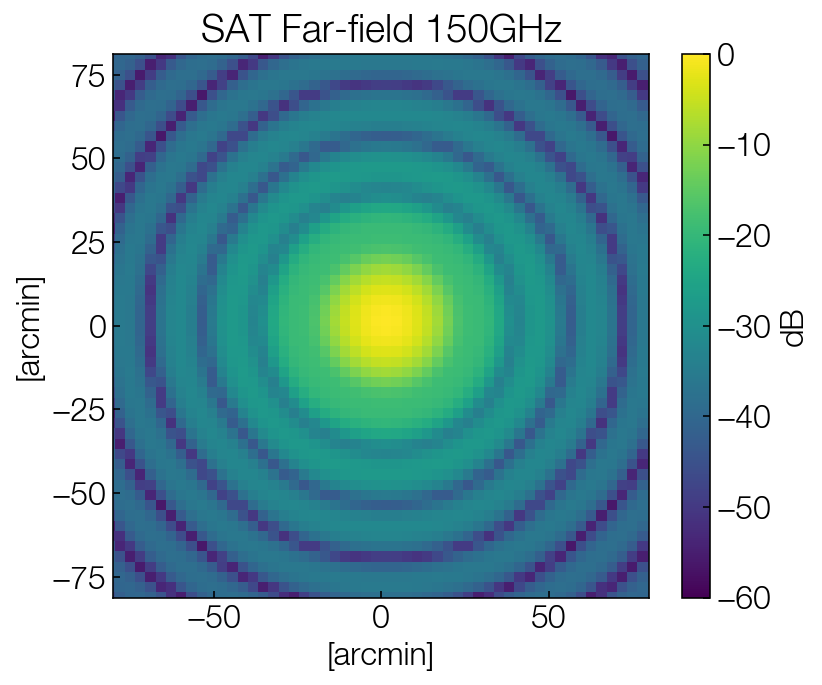

In [105]:
# Zero padding: to increase the resolution of our far-field
# we zero-pad the aperture fields before propagating.  Set
# the number of pixels to pad to the array.
pix_num = 200

x_new, y_new, beam_final = opt_analyze.zero_pad(x, y, beam_conv, pix_num)
print(((x_new[0,0] - x_new[0,1])))
print(((np.max(x_new) - np.min(x_new))))

phase = np.arctan2(np.imag(beam_final), np.real(beam_final))
beam_fft, phase_fft = opt_analyze.a2b(beam_final, phase * 180 / np.pi)

x_ang, y_ang = opt_analyze.coords_spat_to_ang(
    x_new / 1e2, y_new / 1e2, opt_analyze.m_to_ghz(tele_geo.lambda_)
)

plt.figure(figsize=(6, 5))
plt.title("SAT Far-field 150GHz")
plt.pcolormesh(
    x_ang * 180 * 60 / np.pi,
    y_ang * 180 * 60 / np.pi,
    20 * np.log10(abs(beam_fft) / np.max(abs(beam_fft))),
    vmin=-60,
    shading="auto",
)
plt.xlabel("[arcmin]")
plt.ylabel("[arcmin]")
plt.colorbar(label="dB")
plt.axis("equal")
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.show()

## Predicted Beam Size
Our simulated beam size determines the resolution of our telescope.  We can compare this to the beam size of an Airy disc with aperture $D$ at wavelength $\lambda$:

$$\theta_{FWHM} = 1.025 \frac{\lambda}{D} $$

In [106]:
a = abs(beam_fft) ** 2 / np.max(abs(beam_fft) ** 2)
x_out = y_ang
y_out = x_ang

indx = np.where(abs(a) == np.max(abs(a)))
x = y_out[indx[0][0], :] * 60 * 180 / np.pi
y = abs(a)[indx[0][0], :] / np.max(abs(a))
v1 = x[np.where((y > 0.5))][0]
v2 = x[np.where((y > 0.5))][-1]

fwhm1 = abs(v1 - v2)

indx = np.where(abs(a) == np.max(abs(a)))
x = x_out[:, indx[1][0]] * 60 * 180 / np.pi
y = abs(a)[:, indx[1][0]] / np.max(abs(a))
v1 = x[np.where((y > 0.5))][0]
v2 = x[np.where((y > 0.5))][-1]

fwhm2 = abs(v1 - v2)
fwhm = (fwhm1 + fwhm2) / 2
print(f"Simulated beam size: {fwhm:.2f} arcmin.")
print(
    f"Predicted beam size: {opt_analyze.rad_to_arcmin((1.025*tele_geo.lambda_ /tele_geo.diam)):.2f} arcmin."
)

Simulated beam size: 18.37 arcmin.
Predicted beam size: 16.78 arcmin.
